# Fitting Gaussian functions
***
Fitting Gaussians to data is pretty much our bread and butter, we do it all of the time on all kinds of data. This notebook starts where the finding local maxima notebook left off, and shows how to assign a position to each maximum based on a 2D Gaussian fit.   


<IPython.core.display.Javascript object>


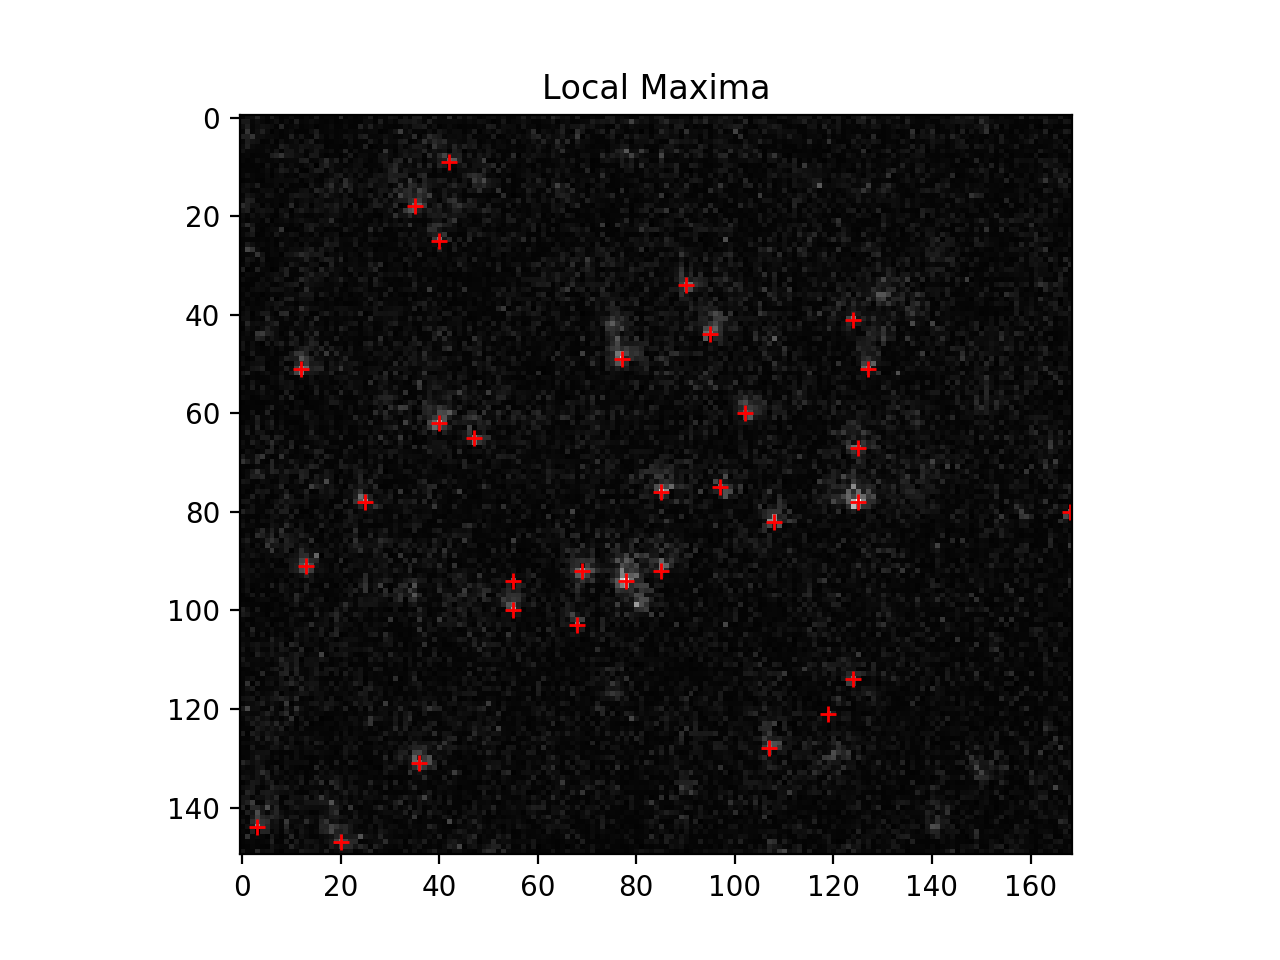

In [1]:
%matplotlib notebook
from skimage.external.tifffile import imread
from skimage.filters import threshold_otsu
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

fname = 'test_images/test_image_2.tif'
im = imread(fname)

size = 10
im_max = filters.maximum_filter(im, size)
im_min = filters.minimum_filter(im, size)
im_diff = im_max - im_min

maxima=(im==im_max)
thresh = threshold_otsu(im_diff)
bool_diff = (im_diff < thresh)
maxima[bool_diff] = False

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
points = []
for dy,dx in slices:
    points.append((dx.start,dy.start))   
plt.figure()
plt.title("Local Maxima")
plt.imshow(im,cmap=plt.cm.gray)
plt.plot(*zip(*points), 'r+')

In [2]:
import numpy as np

#- This bit here is for the plotting.
#- N is the size of the subplot grid
N = int(np.ceil(np.sqrt(len(points))))

#- This is size of box we draw around each point
#- to do the gaussian fitting
bbox = 7
#- half the size of the box rounded down
db = int(np.floor(bbox/2))

To get started, lets grab all of the pixels in a `bbox`-sized square around each located maximum, plot them individually, and have a look at them.

<IPython.core.display.Javascript object>


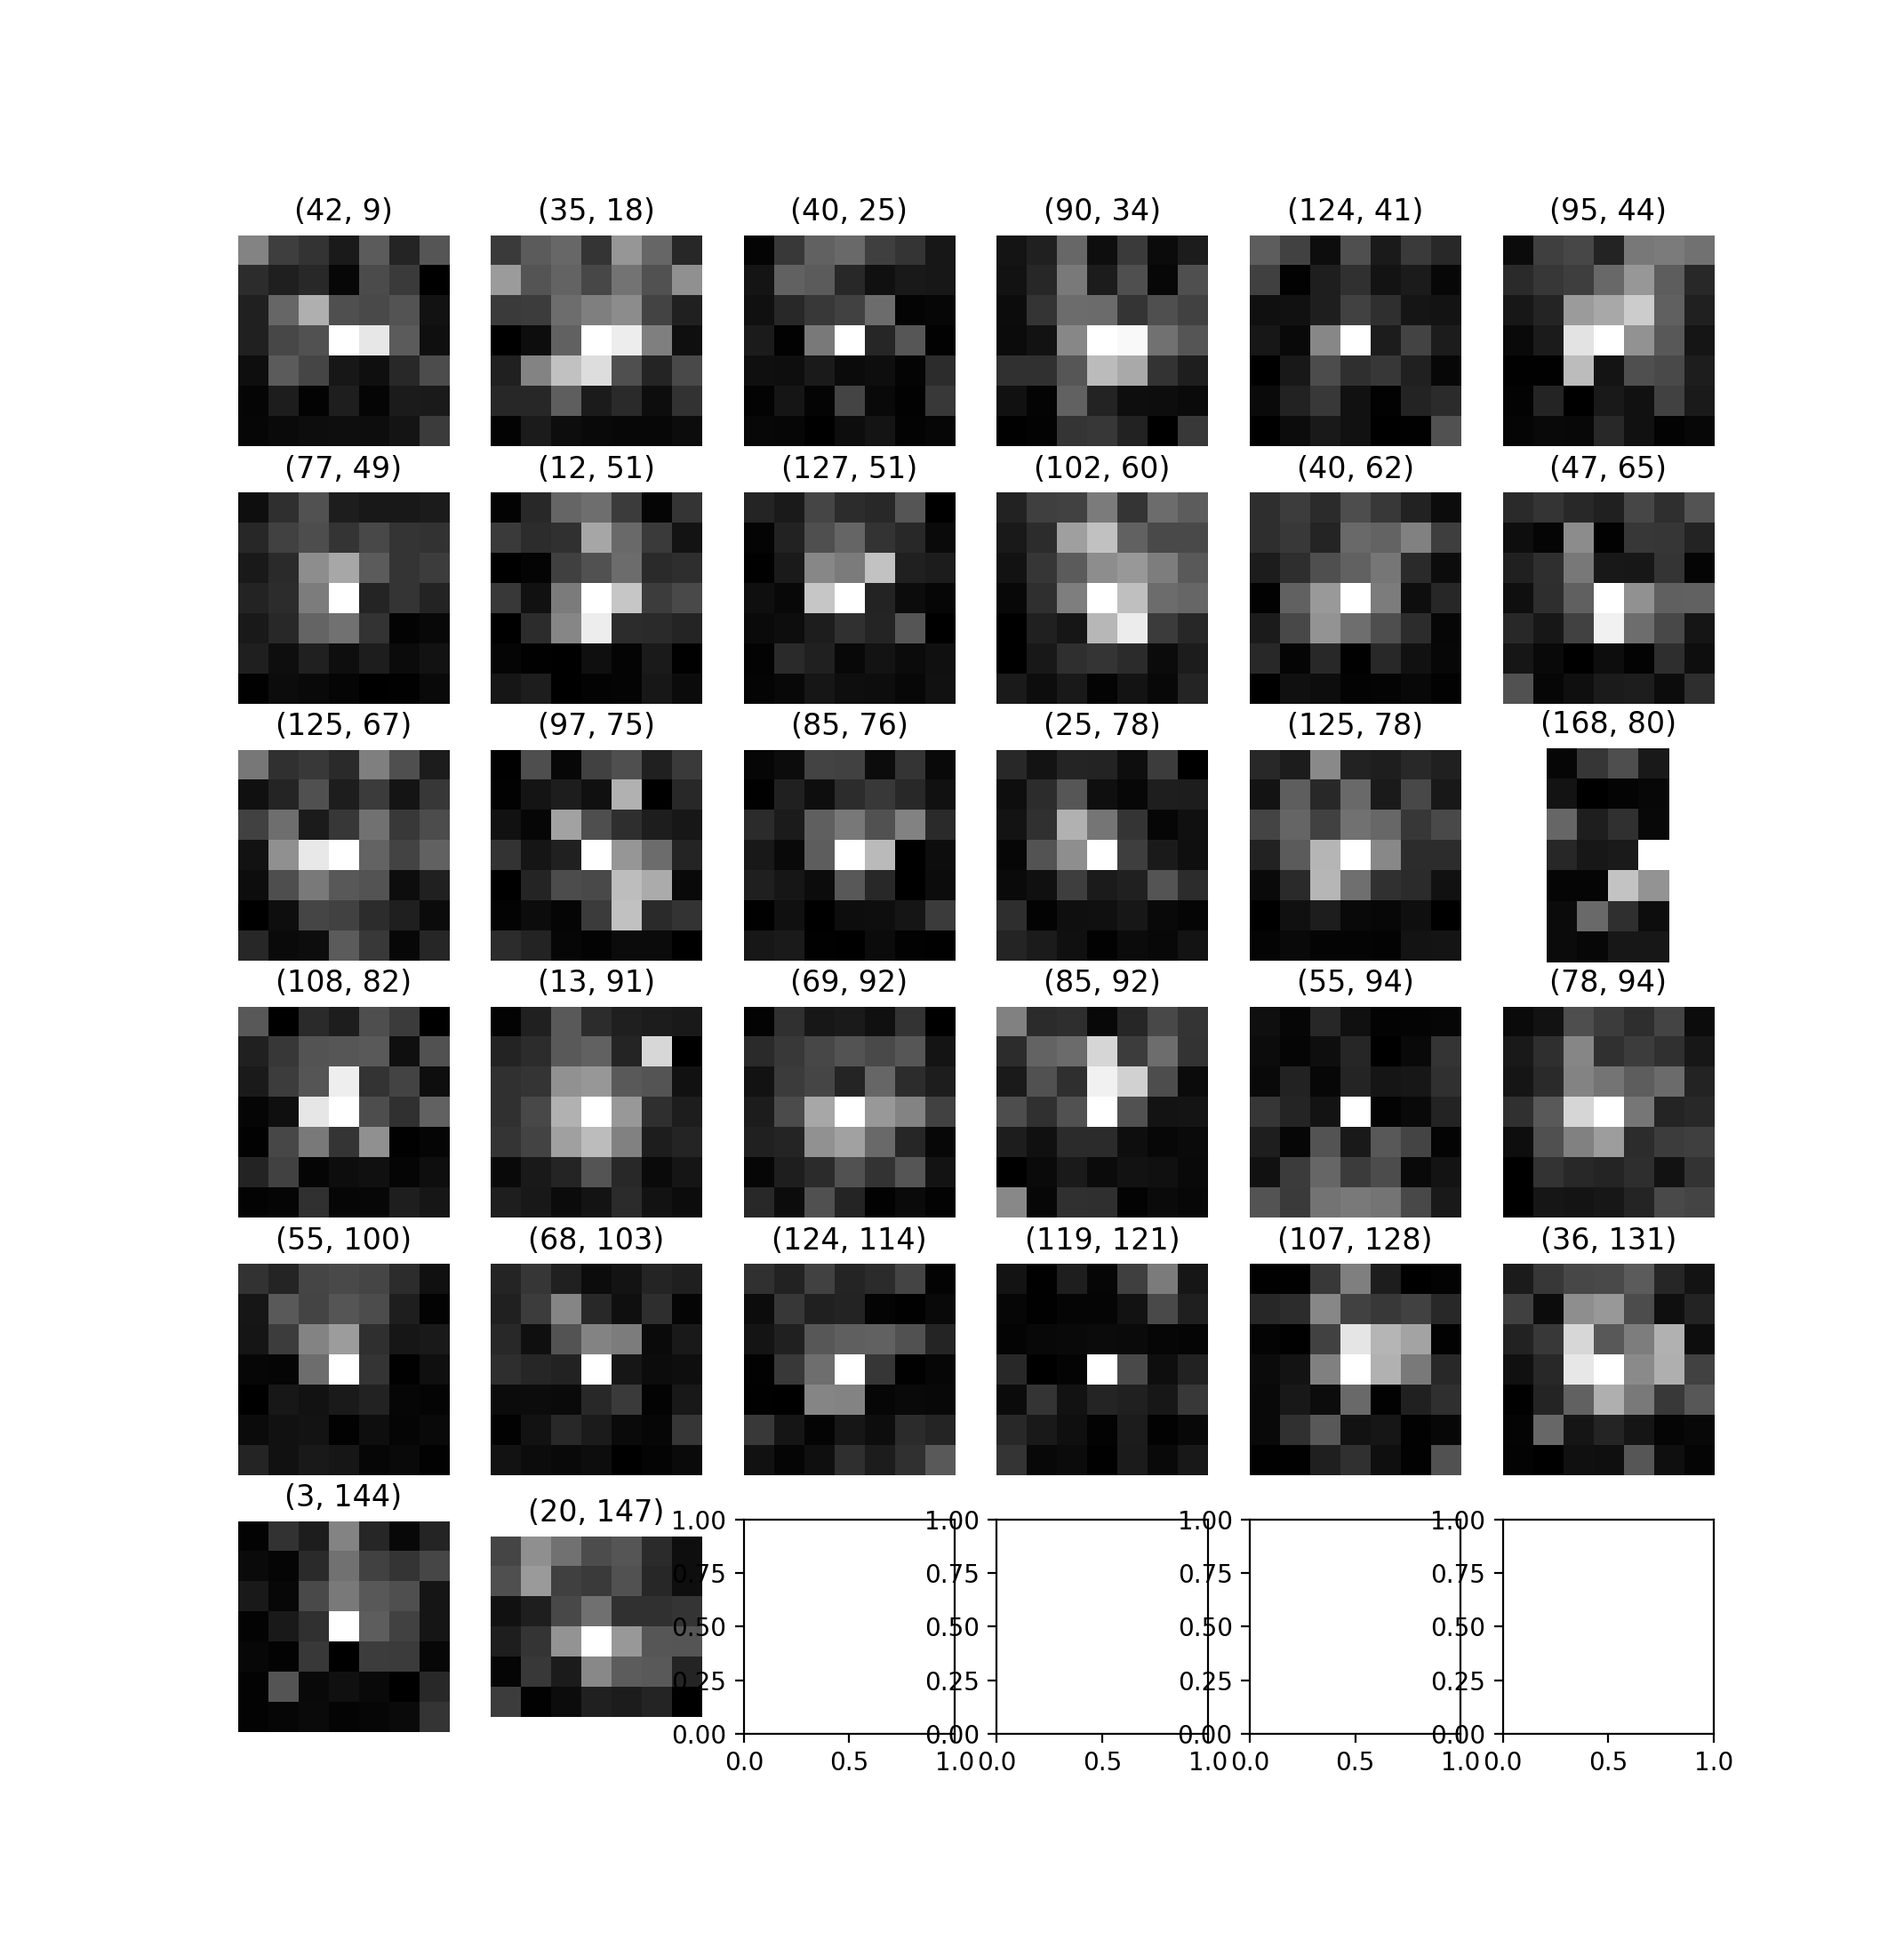

In [3]:
fig, axes = plt.subplots(nrows=N, ncols=N)
axlist = [i for i in axes.flat]
count = 0
for i,j in points:
    axlist[count].imshow((im[j-db:j+db+1, i-db:i+db+1]),cmap=plt.cm.gray)
    axlist[count].set_title(str(points[count]))
    axlist[count].axis('off')
    count+=1
    

 

Notice that two of the regions are smaller than the rest. `(20,147)` and `(168,80)` are both truncated by the edges of the full image. We are going to set a trap below to identify maxima too close to the edges and toss these maxima out of our analysis.  

But before that, we first define our Gaussian function for the fit.

In [4]:
##-- Definition of 2-D gaussian --##
##-- from MMK
def twoD_Gaussian(A, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x,y = A[0],A[1]
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))
    return g.ravel()

Okay, lets give this function a test drive. We will try fitting just the first maxima in the list.

<IPython.core.display.Javascript object>


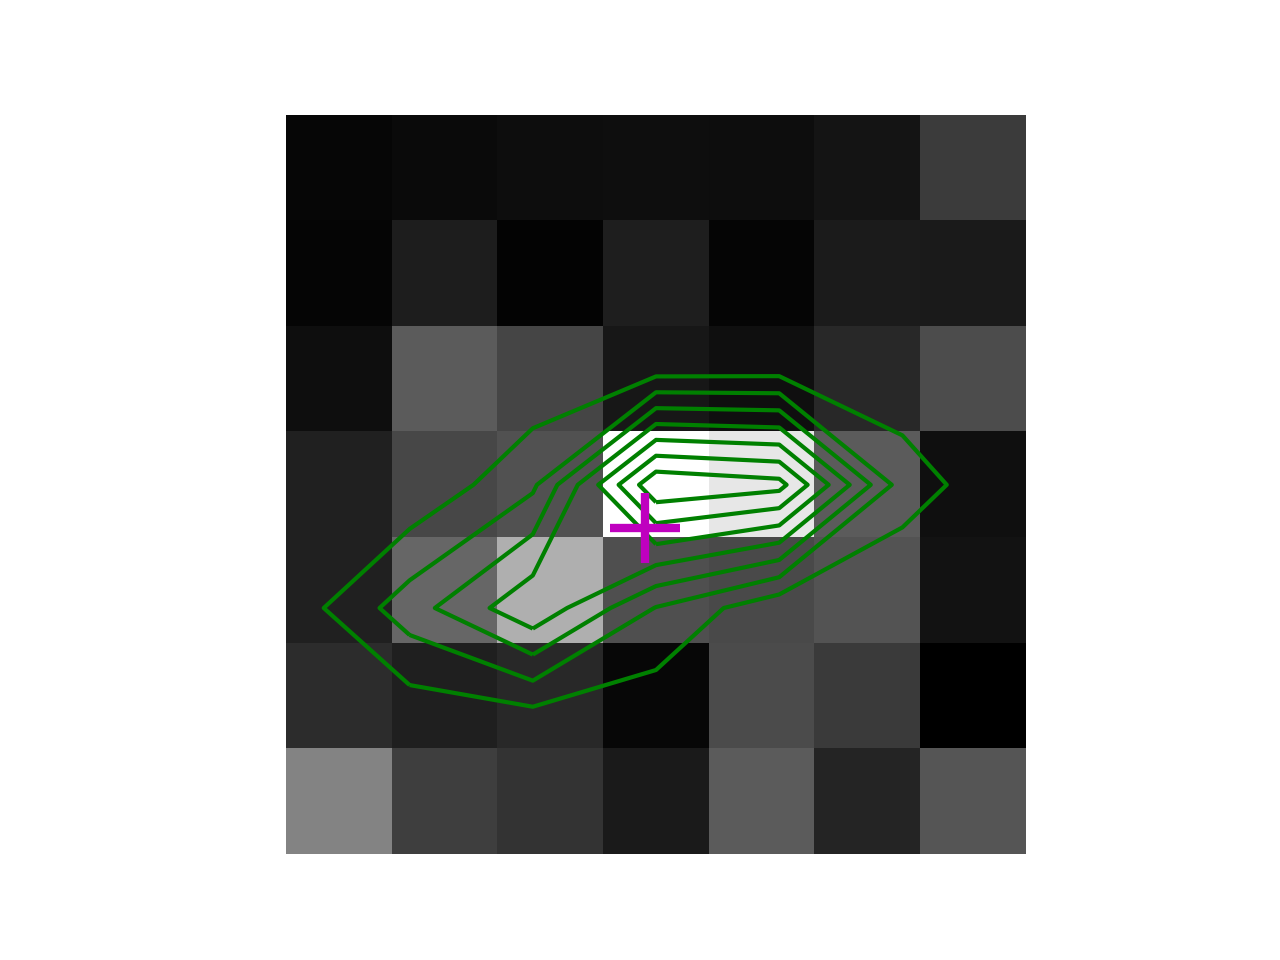

In [5]:
from scipy.optimize import curve_fit

#- Just the first maxima
i,j = points[0][0], points[0][1]

#- We create a 1D array of numbers for each i and j.
#- starting at i-db and going to i+db (or j-db to j+db)
span_x = np.linspace(i-db,i+db, bbox)
span_y = np.linspace(j-db,j+db, bbox)

#- This creates a 2D array from the 1D arrays above
X,Y = np.meshgrid(span_x, span_y)

#- This is the 2D array of pixel intensity
#- values from the image
values = (im[j-db:j+db+1, i-db:i+db+1]).ravel()

#- normalize the array to maximum = 1
scaled = [i/max(values) for i in values]

#- Here we offer an initial guess for the guassian function
#- Initial guesses can have a ton of influence on whether or 
#- not the optimization routine will find a good fit. 
initial_guess = (1, i, j, 1, 1, 0, 0)
    
#- Do the fit    
popt, pcov = curve_fit(twoD_Gaussian, (X, Y), scaled, p0=initial_guess)
data_fitted = twoD_Gaussian((X, Y), *popt)

#- the reshape biz is just converting the 2D array list into a list of 1D lists
plt.figure()
plt.imshow(values.reshape(7, 7), cmap=plt.cm.gray, origin='bottom', 
          extent=(X.min(), X.max(), Y.min(), Y.max()),interpolation="none")
plt.axis('off')
plt.contour(span_x, span_y, data_fitted.reshape(7, 7), 8, colors='g')
plt.plot(popt[1], popt[2], 'm+', markersize=25, markeredgewidth = 3)

What do we think of this fit? Is it good? To decide whether or not to feel confident in the fit, we should consider the error terms, _i.e._ what's the +/- on the mean? are the variances crazy huge and weird? when we called `curve_fit`, we defined the covariance matrix as `pcov`. The diagonal terms of this matrix are the variances. Lets see how they look.


In [6]:
print("mean x: ", popt[1], ", deviation: ", np.sqrt(pcov[1][1]) )
print("mean y: ", popt[2], ", deviation: ", np.sqrt(pcov[2][2]) )
print("sigma x: ", popt[3])
print("sigma y: ", popt[4])

mean x:  41.91303920193523 , deviation:  0.2728587435333469
mean y:  8.64653110103373 , deviation:  0.161713499663916
sigma x:  1.1347460329250756
sigma y:  0.33372923398254317


They're actually pretty good. The error on the mean position is less than a pixel in both dimensions, and the Gaussian isn't totally batshit skewed with huge standard deviations. Lets try our algorithm out on the whole set of maxima and see how the fits come out for the rest.

<IPython.core.display.Javascript object>


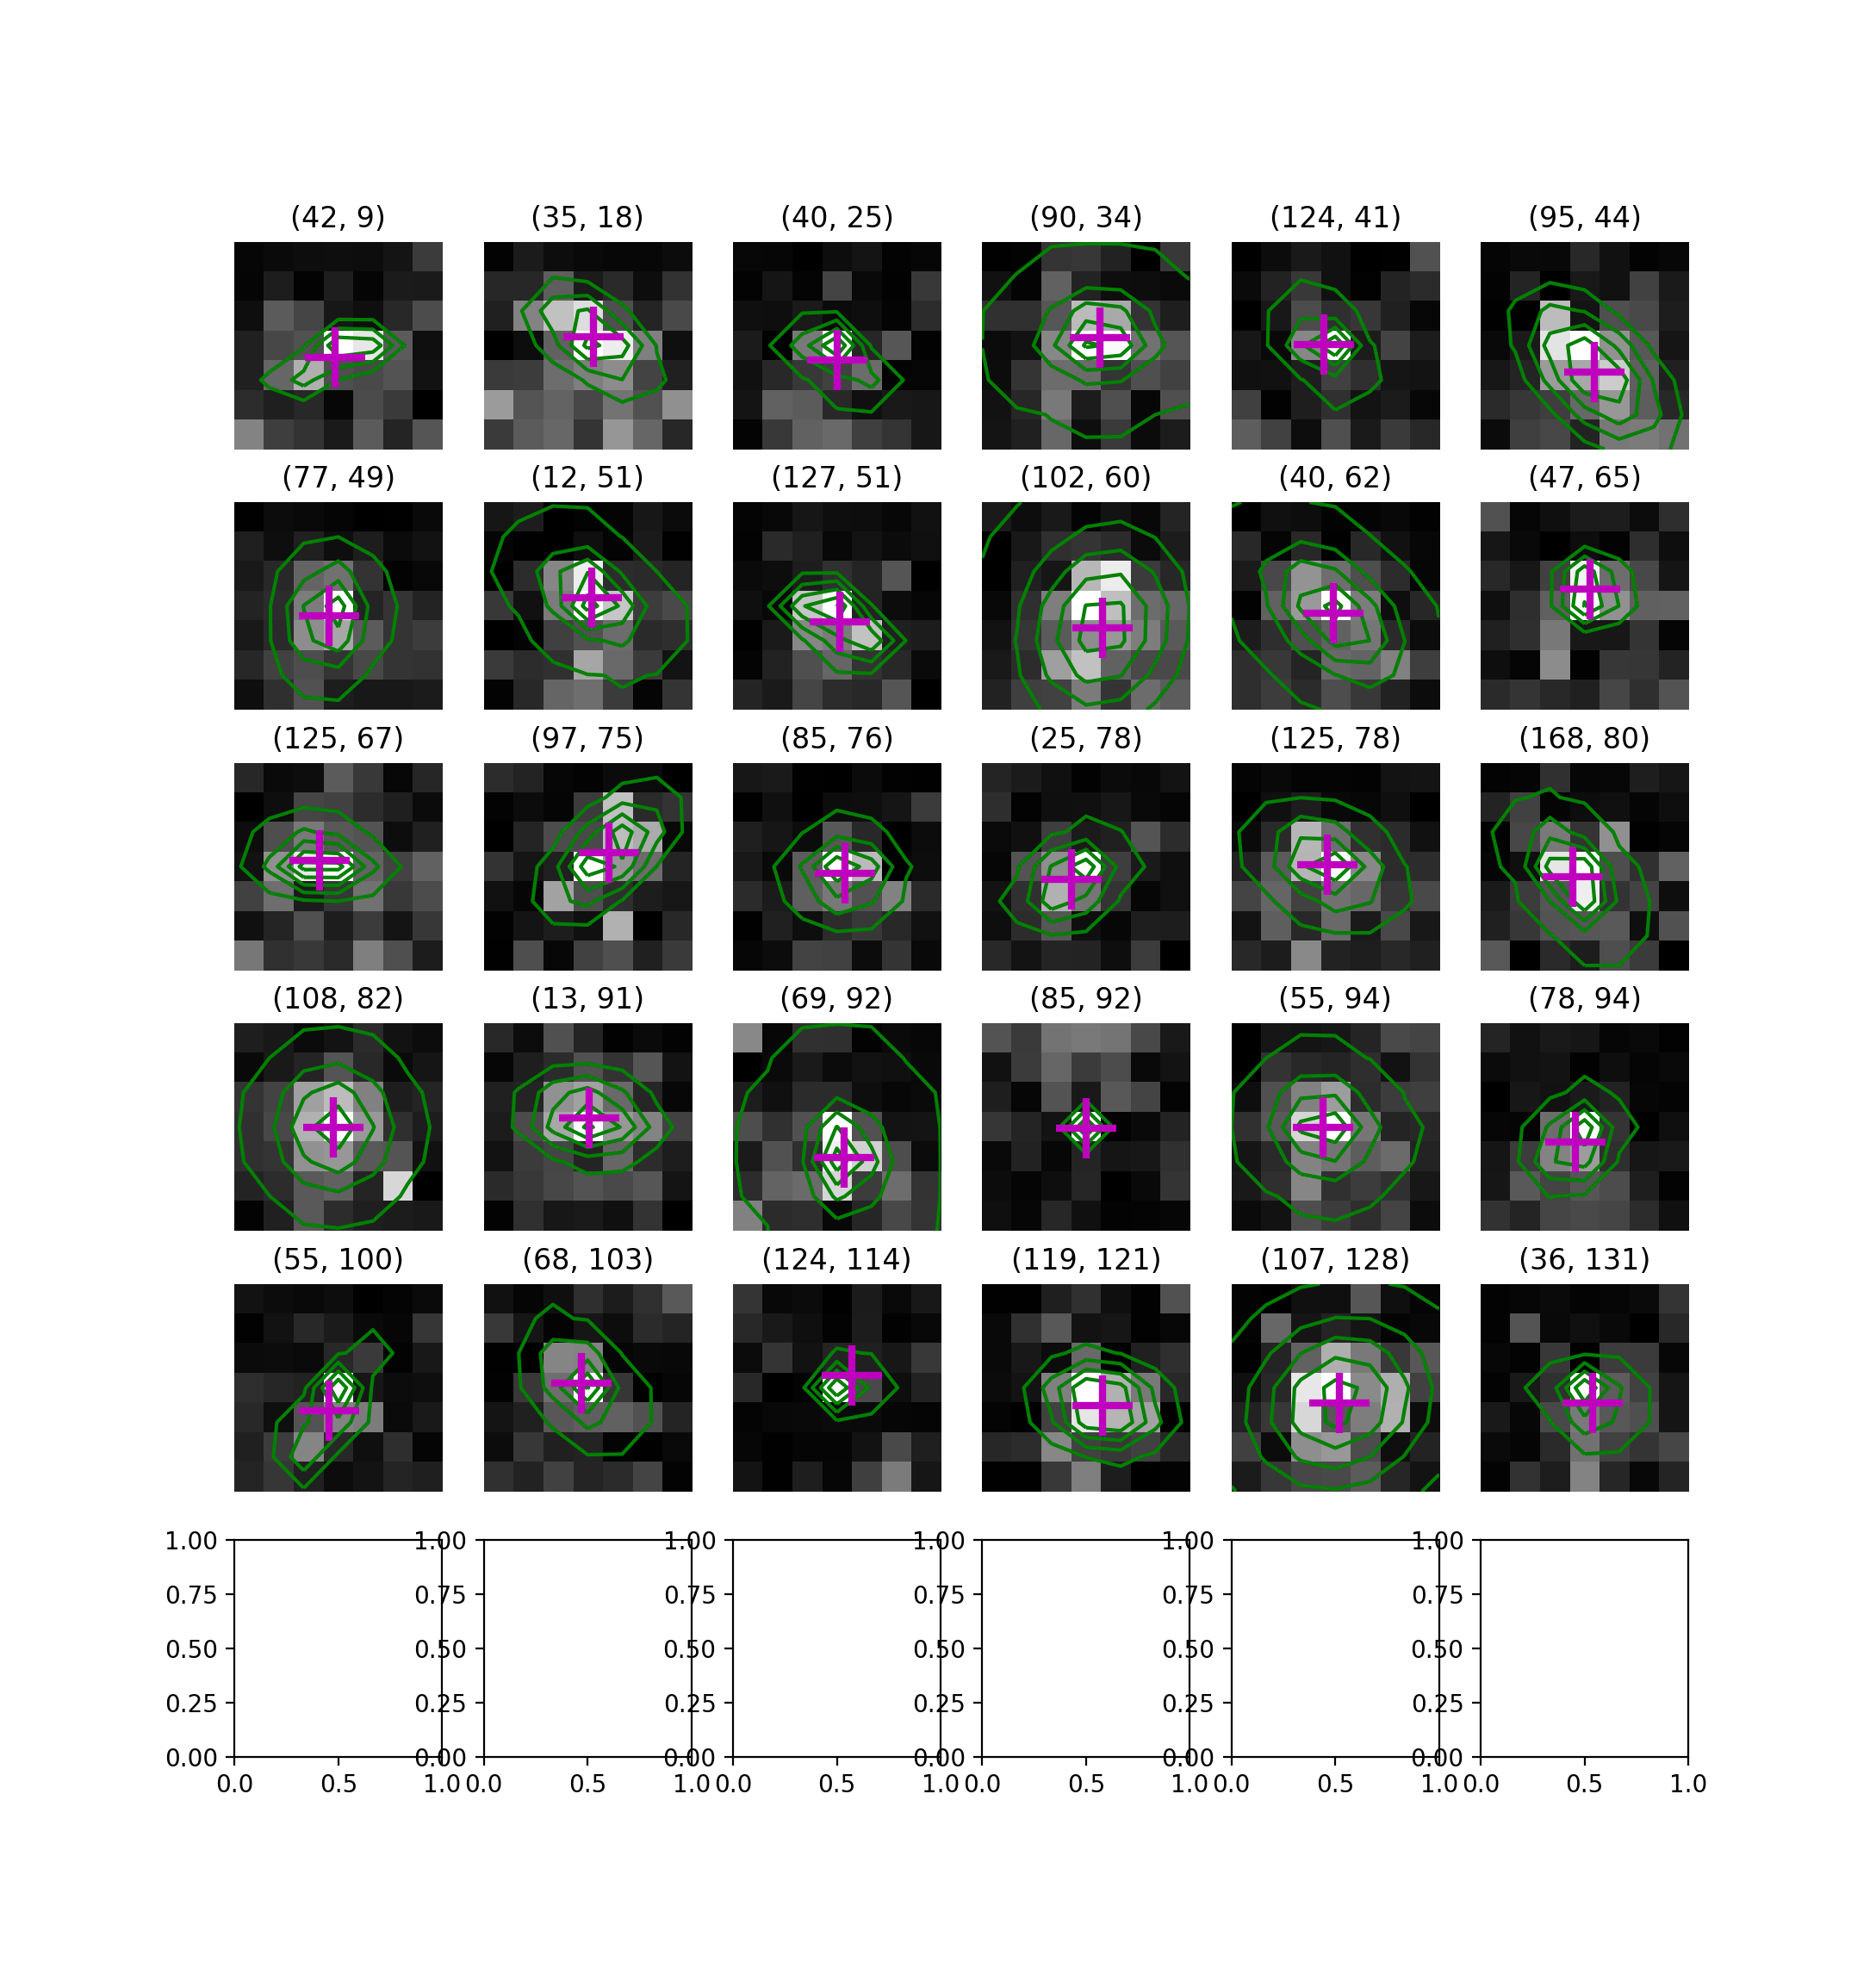

In [7]:
fig, axes = plt.subplots(nrows=N, ncols=N, sharex=False, sharey=False)
axlist = [i for i in axes.flat]
count = 0
for i,j in points:
    span_x = np.linspace(i-db,i+db, bbox)
    span_y = np.linspace(j-db,j+db, bbox)
    X,Y = np.meshgrid(span_x, span_y)
    values = (im[j-db:j+db+1, i-db:i+db+1]).ravel()
    scaled = [k/max(values) for k in values]
    
    #- Here is where we set our trap for the maxima that are too close to the edges
    if len(values)==bbox**2:
        axlist[count].imshow(values.reshape(7, 7), cmap=plt.cm.gray, origin='bottom', 
              extent=(X.min(), X.max(), Y.min(), Y.max()),interpolation="none")
        axlist[count].set_title(str(points[count]))
        axlist[count].axis('off')
        
        #- Here we can see how the initial guess can affect how well the optimization 
        #- routine does. There is one maxima in our set that fails to find optimal parameters
        #- with the first guess, but succeeds with the second. In general we will need to 
        #- be more sophisticated with our exception handling. 
        try:
            initial_guess = (1, i, j, 1, 1, 0, 0)
            popt, pcov = curve_fit(twoD_Gaussian, (X, Y), scaled, p0=initial_guess)
            
        #- here we guess that the amplitude of the gaussian function is 0.1 instead of 1, even
        #- though we scaled the data to one. If you would like to be entertained you should 
        #- print out what the routine finds for A with this new intial guess... its really something.
        except RuntimeError:
            initial_guess = (.1, i, j, 1, 1, 0, 0)
            popt, pcov = curve_fit(twoD_Gaussian, (X, Y), scaled, p0=initial_guess)

        data_fitted = twoD_Gaussian((X, Y), *popt)
        axlist[count].contour(span_x, span_y, data_fitted.reshape(7, 7), 4, colors='g')
        axlist[count].plot(popt[1], popt[2], 'm+', markersize=25, markeredgewidth = 3)

        count+=1
    

Well, the algorithm works; we got rid of the edge data, and we do get fits for each maxima. Some of the fits look a bit suspect though. Consider `(85,92)`, that mess is straight up just fitting a single pixel. I wonder what the error looks like on that one? 
  
  
Lets re-run our algorithm but this time I want to require that the error on the mean position is below an "acceptable" amount. How should I decide this threshold? And moreover, how does this error relate to our resolution?

<IPython.core.display.Javascript object>


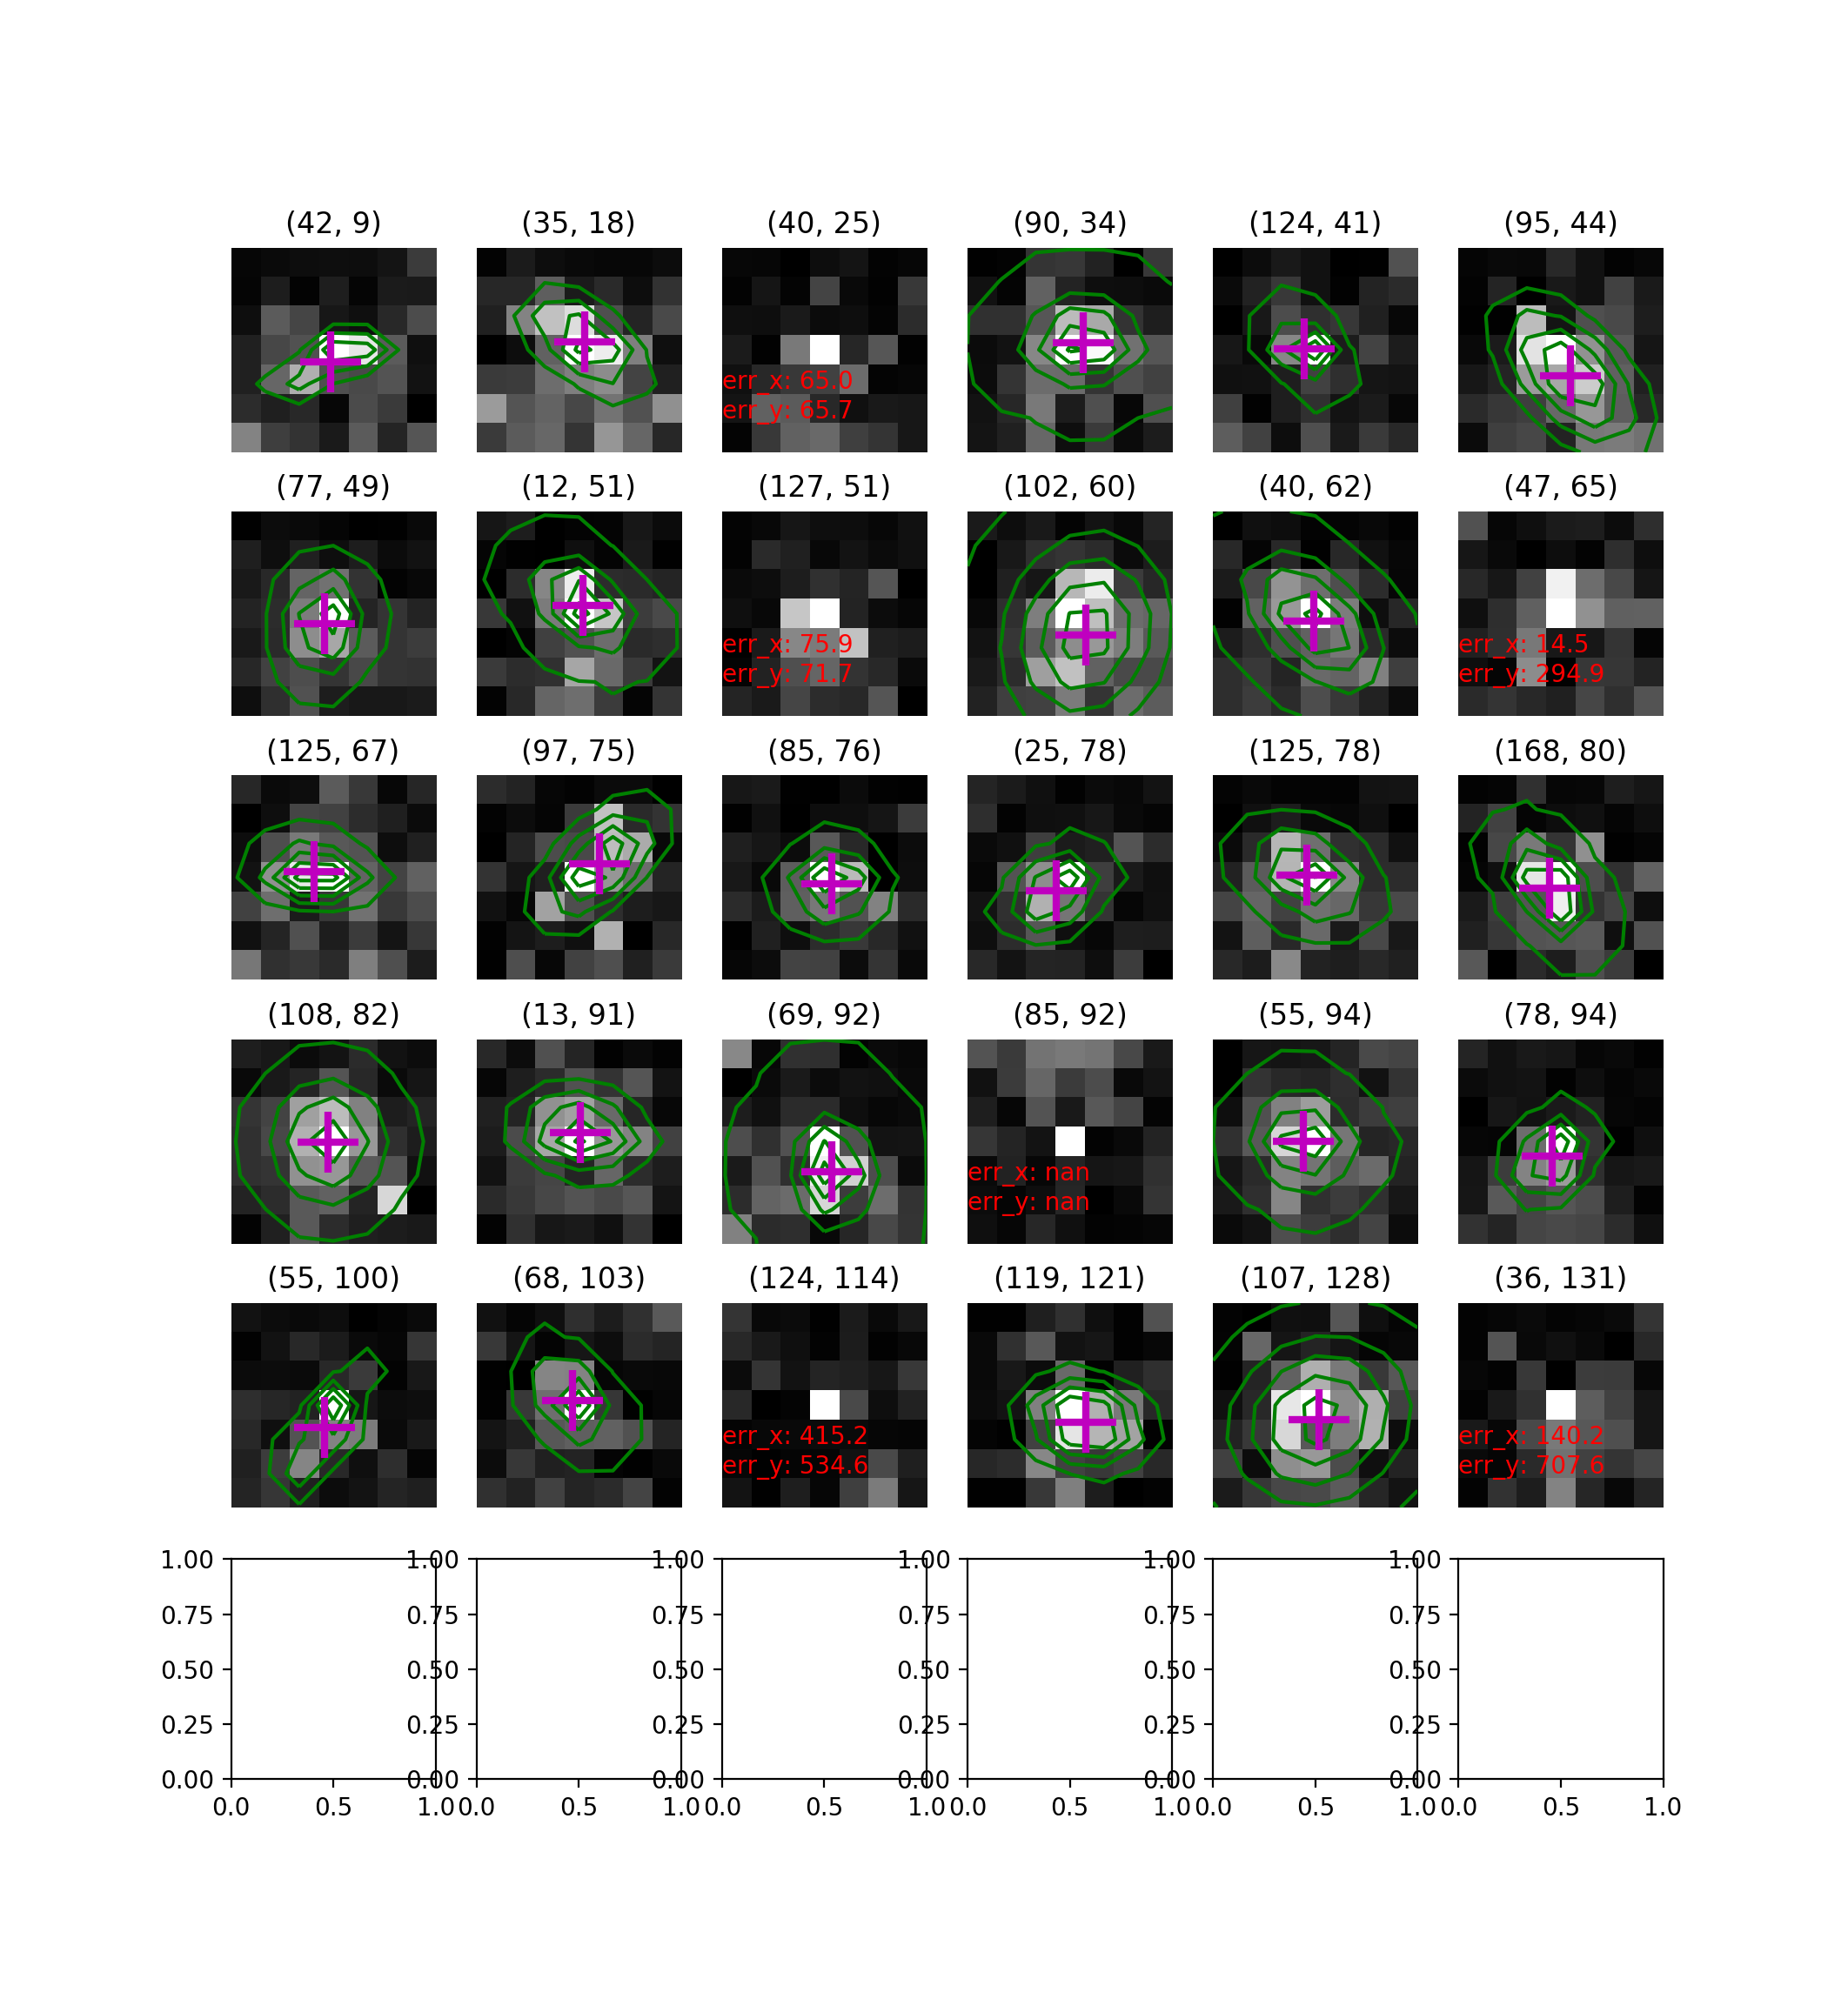

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


In [8]:
spotx, spoty, difference = [],[],[]

#- Here we define our acceptable error in terms of pixels
#- Im going with a third of a pixel, fite me.
error = .3

fig, axes = plt.subplots(nrows=N, ncols=N, sharex=False, sharey=False)
axlist = [i for i in axes.flat]
count = 0
for i,j in points:
    span_x = np.linspace(i-db,i+db, bbox)
    span_y = np.linspace(j-db,j+db, bbox)
    X,Y = np.meshgrid(span_x, span_y)
    values = (im[j-db:j+db+1, i-db:i+db+1]).ravel()
    scaled = [k/max(values) for k in values]
    if len(values)==bbox**2:
        axlist[count].imshow(values.reshape(7, 7), cmap=plt.cm.gray, origin='bottom', 
              extent=(X.min(), X.max(), Y.min(), Y.max()),interpolation="none")
        axlist[count].set_title(str(points[count]))
        axlist[count].axis('off')
        
        try:
            initial_guess = (1, i, j, 1, 1, 0, 0)
            popt, pcov = curve_fit(twoD_Gaussian, (X, Y), scaled, p0=initial_guess)
            
        except RuntimeError:
            initial_guess = (.1, i, j, 1, 1, 0, 0)
            popt, pcov = curve_fit(twoD_Gaussian, (X, Y), scaled, p0=initial_guess)
        
            
        #- apply the error threshold
        if np.sqrt(pcov[1][1])<=error and np.sqrt(pcov[2][2])<=error:
            data_fitted = twoD_Gaussian((X, Y), *popt)
            axlist[count].contour(span_x, span_y, data_fitted.reshape(7, 7), 4, colors='g')
            axlist[count].plot(popt[1], popt[2], 'm+', markersize=25, markeredgewidth = 3)
                
            spotx.append(popt[1])
            spoty.append(popt[2])
                
            #- Here we are measuring the difference between the maxima pixel position
            #- and the final assigned mean. This is to get an idea of the magnitude
            #- of correction that we get from fitting gaussians. The 266 comes in here
            #- because the image we are analyzing was captured with a 60X objective
            #- and given our CCD chip size, each pixel is 266.66nm X 266.66nm
            difference.append((abs(i-popt[1])*266.66,abs(j-popt[2])*266.66))
        
        else:
            string = "err_x: "+ str(round(np.sqrt(pcov[1][1]),1))+" \nerr_y: "+str(round(np.sqrt(pcov[2][2]),1))
            axlist[count].text(i-3, j-2, string, color = "red")
       
        count+=1
    

It's certainly interesting to see which ones fail our criteria and which pass. We even have one with negative valued variance, how's that for problematic! When you are processing your real data, you should spend time thinking about how you define aceptable fits and error. As with all data, there is a trade off between strigent selection criteria and overly censoring data as well as the inverse. Furthermore, as is always the case with our data, time spent optimizing the data collection to look the nicest pays huge dividends relative to spending time optimizing error and exception handling. 
  
Okay, lets have a look at the new fits versus the original maxima positions.   

<IPython.core.display.Javascript object>


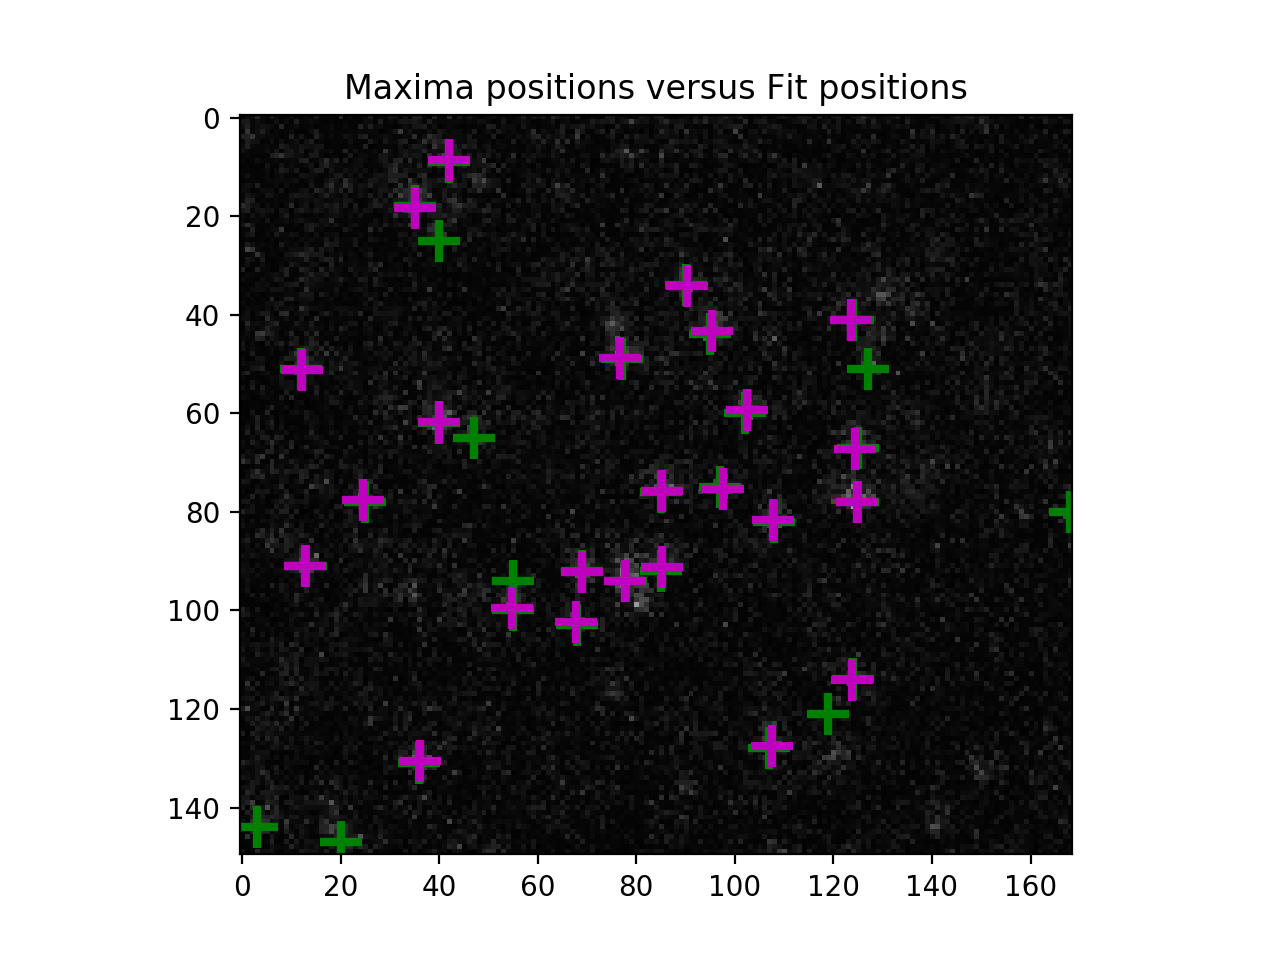

In [9]:
plt.figure()
plt.title("Maxima positions versus Fit positions")
plt.imshow(im,cmap = "binary_r")
plt.plot(*zip(*points), 'g+',markersize=15,markeredgewidth = 3)
plt.plot(spotx,spoty, 'm+',markersize=15,markeredgewidth = 3)

Whoa, huge differences. Seriously though, why even bother? these all look the same. Lets have a look at how far our estimation of position changed by plotting the difference between the green and magenta positions in $nm$.

<IPython.core.display.Javascript object>


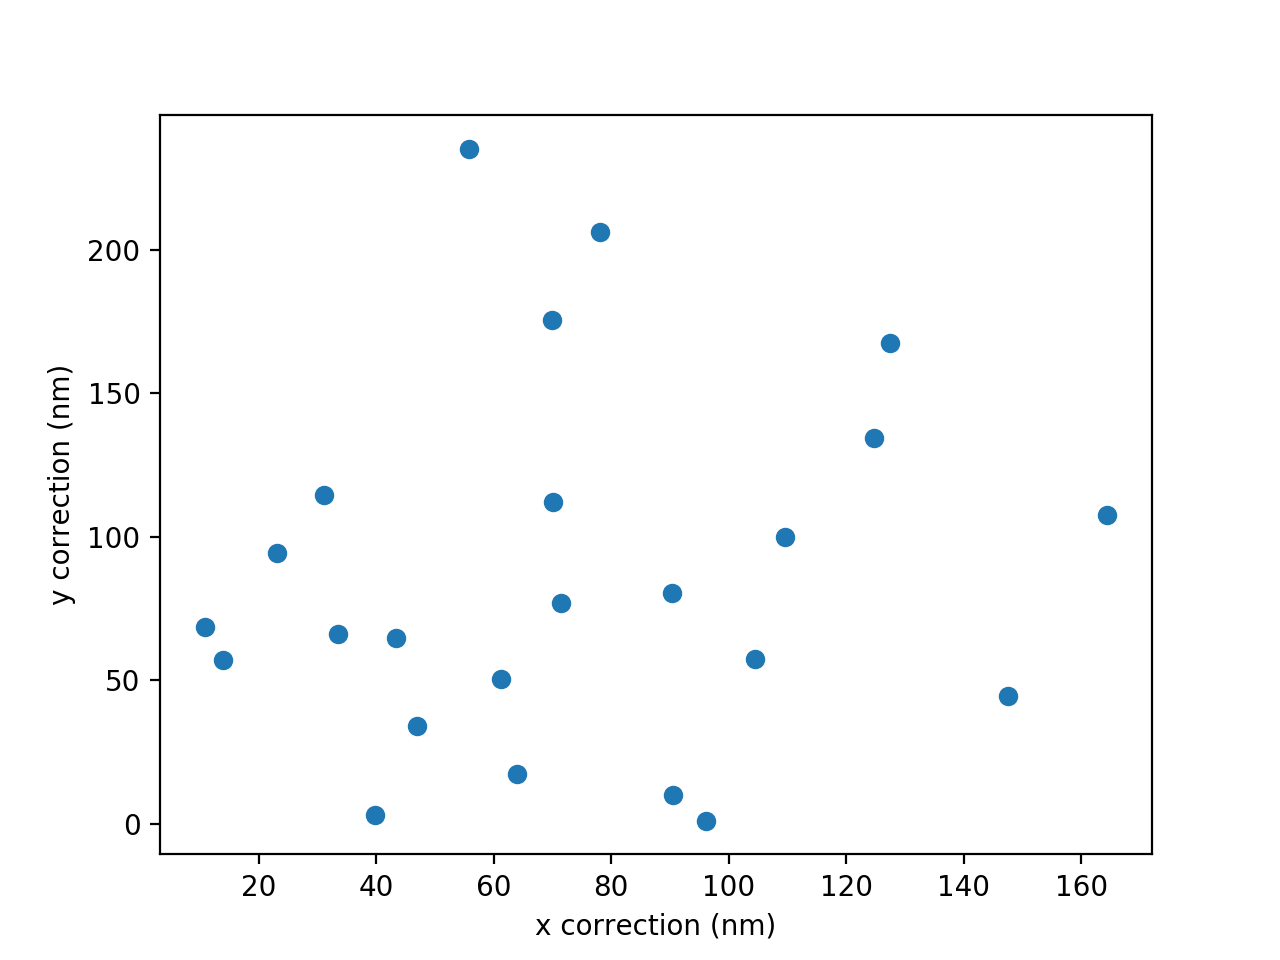

average x correction:  73.68306989355897
average y correction:  86.6588477332985


In [10]:
x,y = zip(*difference)
plt.scatter(x,y)
plt.xlabel("x correction (nm)")
plt.ylabel("y correction (nm)")
print("average x correction: ", np.mean(x))
print("average y correction: ", np.mean(y))



Well, well, well, $80nm$ is nothing to sniff at. It is certainly a shit ton of basepairs, so in the end it really does seem to be advantageous for us to perform the fits.